In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/vinbigdata-chest-xray-abnormalities-detection/sample_submission.csv
/kaggle/input/vinbigdata-chest-xray-abnormalities-detection/train.csv
/kaggle/input/vinbigdata-chest-xray-abnormalities-detection/test/83caa8a85e03606cf57e49147d7ac569.dicom
/kaggle/input/vinbigdata-chest-xray-abnormalities-detection/test/7550347fa2bb96c2354a3716dfa3a69c.dicom
/kaggle/input/vinbigdata-chest-xray-abnormalities-detection/test/74b23792db329cff5843e36efb8aa65a.dicom
/kaggle/input/vinbigdata-chest-xray-abnormalities-detection/test/94568a546be103177cb582d3e91cd2d8.dicom
/kaggle/input/vinbigdata-chest-xray-abnormalities-detection/test/6da36354fc904b63bc03eb3884e0c35c.dicom
/kaggle/input/vinbigdata-chest-xray-abnormalities-detection/test/5b3620a56668010877cfafa9322e18b5.dicom
/kaggle/input/vinbigdata-chest-xray-abnormalities-detection/test/5157d5c9b1f0004b29310652ea54e825.dicom
/kaggle/input/vinbigdata-chest-xray-abnormalities-detection/test/74897408dcbd69ef7c76cbbbbeb722d6.dicom
/kaggle/input/vi

In [2]:
# Install + Import Libraries
# DICOM processing library
!pip install -q pydicom

import os
import cv2
import numpy as np
import pydicom
import matplotlib.pyplot as plt
from tqdm import tqdm

# Fix randomness
import random
random.seed(42)
np.random.seed(42)

print("Libraries Loaded!")


Libraries Loaded!


In [25]:
train_files = [f for f in os.listdir(os.path.join(INPUT_DIR, "train")) if f.endswith('.dicom')]
test_files  = [f for f in os.listdir(os.path.join(INPUT_DIR, "test")) if f.endswith('.dicom')]

print("📌 Training images:", len(train_files))
print("📌 Testing images :", len(test_files))
print("📌 Total images   :", len(train_files) + len(test_files))


📌 Training images: 15000
📌 Testing images : 3000
📌 Total images   : 18000


In [12]:
# Set Paths & Configurations
# Path to your Kaggle dataset
# (You already confirmed this path)
INPUT_DIR = "/kaggle/input/vinbigdata-chest-xray-abnormalities-detection"

DICOM_DIR = os.path.join(INPUT_DIR, "train")   # contains DICOM images
ANNOT_FILE = os.path.join(INPUT_DIR, "train.csv")  # contains bounding boxes

# Output folders
OUTPUT_ROOT = "/kaggle/working/vinbig_processed"
RAW_PNG_DIR = os.path.join(OUTPUT_ROOT, "png_images")  # after DICOM → PNG
FINAL_DIR = os.path.join(OUTPUT_ROOT, "processed_640")

os.makedirs(RAW_PNG_DIR, exist_ok=True)
os.makedirs(FINAL_DIR, exist_ok=True)

# Process only first N images (for testing)
LIMIT = 1000   # change to None later

TARGET_SIZE = 640  # final size

print("Input:", DICOM_DIR)
print("Output:", FINAL_DIR)

# Path to your Kaggle dataset
# (You already confirmed this path)
INPUT_DIR = "/kaggle/input/vinbigdata-chest-xray-abnormalities-detection"

DICOM_DIR = os.path.join(INPUT_DIR, "train")   # contains DICOM images
ANNOT_FILE = os.path.join(INPUT_DIR, "train.csv")  # contains bounding boxes

# Output folders
OUTPUT_ROOT = "/kaggle/working/vinbig_processed"
RAW_PNG_DIR = os.path.join(OUTPUT_ROOT, "png_images")  # after DICOM → PNG
FINAL_DIR = os.path.join(OUTPUT_ROOT, "processed_640")

os.makedirs(RAW_PNG_DIR, exist_ok=True)
os.makedirs(FINAL_DIR, exist_ok=True)

# Process only first N images (for testing)
LIMIT = 1000  # change to None later

TARGET_SIZE = 640  # final size

print("Input:", DICOM_DIR)
print("Output:", FINAL_DIR)


Input: /kaggle/input/vinbigdata-chest-xray-abnormalities-detection/train
Output: /kaggle/working/vinbig_processed/processed_640
Input: /kaggle/input/vinbigdata-chest-xray-abnormalities-detection/train
Output: /kaggle/working/vinbig_processed/processed_640


In [13]:
# Convert DICOM → PNG
def dicom_to_png(dicom_path):
    """
    Reads DICOM image, extracts pixel array, rescales to 0–255,
    returns uint8 PNG image.
    """
    dcm = pydicom.dcmread(dicom_path)
    
    # Extract pixel data
    img = dcm.pixel_array.astype(float)

    # Normalize using windowing:
    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    img = (img * 255).astype(np.uint8)

    return img

dicom_files = os.listdir(DICOM_DIR)
if LIMIT:
    dicom_files = dicom_files[:LIMIT]

print(f"Found {len(dicom_files)} DICOM files")

# Convert and save PNGs
for f in tqdm(dicom_files):
    dcm_path = os.path.join(DICOM_DIR, f)
    png_img = dicom_to_png(dcm_path)

    out_name = f.replace(".dicom", ".png")
    cv2.imwrite(os.path.join(RAW_PNG_DIR, out_name), png_img)


Found 1000 DICOM files


100%|██████████| 1000/1000 [23:52<00:00,  1.43s/it]


In [14]:
# Preprocessing Functions (CLAHE, Denoise, Resize)
def normalize_minmax(img):
    img = img.astype(np.float32)
    img = (img - img.min()) / (img.max() - img.min() + 1e-8)
    return (img * 255).astype(np.uint8)

def apply_clahe(img):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    return clahe.apply(img)

def denoise(img):
    img = cv2.GaussianBlur(img, (5,5), 0)
    img = cv2.medianBlur(img, 3)
    return img

def crop_borders(img):
    """Remove blank borders."""
    _, thresh = cv2.threshold(img, 5, 255, cv2.THRESH_BINARY)
    coords = cv2.findNonZero(thresh)
    if coords is None:
        return img
    x, y, w, h = cv2.boundingRect(coords)
    return img[y:y+h, x:x+w]

def resize_pad(img, target=640):
    h, w = img.shape
    scale = target / max(h,w)
    new_h, new_w = int(h*scale), int(w*scale)

    resized = cv2.resize(img, (new_w, new_h))
    top = (target - new_h)//2
    bottom = target - new_h - top
    left = (target - new_w)//2
    right = target - new_w - left

    padded = cv2.copyMakeBorder(resized, top, bottom, left, right,
                                cv2.BORDER_CONSTANT, value=0)
    return padded


In [15]:
# Apply Full Preprocessing Pipeline
png_files = os.listdir(RAW_PNG_DIR)

for f in tqdm(png_files):
    img_path = os.path.join(RAW_PNG_DIR, f)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    # 1. Crop borders
    img = crop_borders(img)

    # 2. Normalize
    img = normalize_minmax(img)

    # 3. CLAHE
    img = apply_clahe(img)

    # 4. Denoise
    img = denoise(img)

    # 5. Resize + pad to 640x640
    img = resize_pad(img, TARGET_SIZE)

    # Save final preprocessed image
    cv2.imwrite(os.path.join(FINAL_DIR, f), img)


100%|██████████| 1000/1000 [04:48<00:00,  3.46it/s]


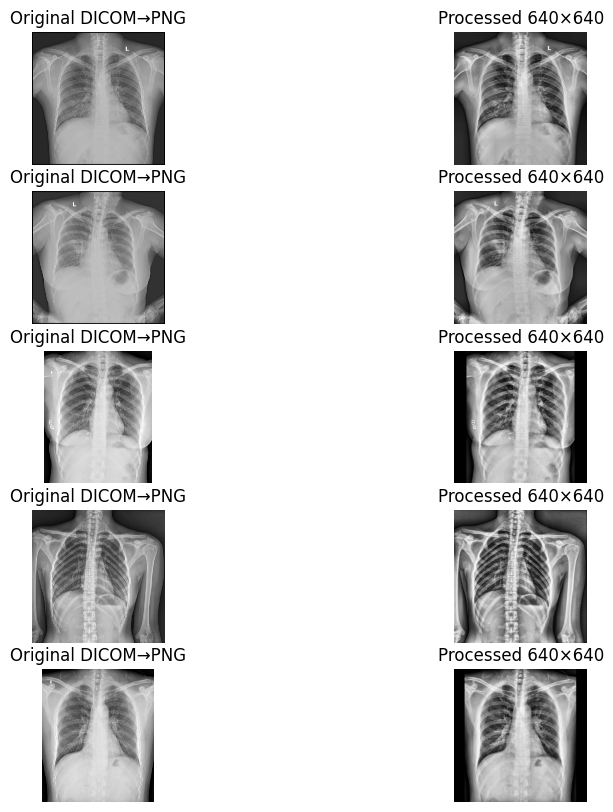

In [16]:
# Visual Check (Before/After)
def show_pairs(n=5):
    sample = png_files[:n]
    plt.figure(figsize=(10, 2*n))

    for i, f in enumerate(sample):
        orig = cv2.imread(os.path.join(RAW_PNG_DIR, f), cv2.IMREAD_GRAYSCALE)
        proc = cv2.imread(os.path.join(FINAL_DIR, f), cv2.IMREAD_GRAYSCALE)

        plt.subplot(n,2,2*i+1)
        plt.imshow(orig, cmap='gray')
        plt.title("Original DICOM→PNG")
        plt.axis('off')

        plt.subplot(n,2,2*i+2)
        plt.imshow(proc, cmap='gray')
        plt.title("Processed 640×640")
        plt.axis('off')

    plt.show()

show_pairs(5)


In [19]:
# ---- CREATE TRAIN / VAL / TEST SPLIT ----

from sklearn.model_selection import train_test_split

# Make sure SPLIT_ROOT exists
SPLIT_ROOT = os.path.join(OUTPUT_ROOT, "split")
train_dir = os.path.join(SPLIT_ROOT, "train")
val_dir   = os.path.join(SPLIT_ROOT, "val")
test_dir  = os.path.join(SPLIT_ROOT, "test")

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# List processed images (final 640×640)
processed_images = [f for f in os.listdir(FINAL_DIR) if f.endswith('.png')]

# Train/Val/Test = 70/15/15
train_files, temp_files = train_test_split(processed_images, test_size=0.30, random_state=42)
val_files, test_files   = train_test_split(temp_files, test_size=0.50, random_state=42)

print(f"Train: {len(train_files)}, Val: {len(val_files)}, Test: {len(test_files)}")

# Copy images to split folders
import shutil

for fname in train_files:
    shutil.copy(os.path.join(FINAL_DIR, fname), os.path.join(train_dir, fname))

for fname in val_files:
    shutil.copy(os.path.join(FINAL_DIR, fname), os.path.join(val_dir, fname))

for fname in test_files:
    shutil.copy(os.path.join(FINAL_DIR, fname), os.path.join(test_dir, fname))

print("✔ Split complete!")


Train: 700, Val: 150, Test: 150
✔ Split complete!


In [20]:
# ---- Count train / val / test images ----

# DEFINE SPLIT_ROOT AGAIN (in case previous cells not run)
SPLIT_ROOT = os.path.join(OUTPUT_ROOT, "split")

train_dir = os.path.join(SPLIT_ROOT, "train")
val_dir   = os.path.join(SPLIT_ROOT, "val")
test_dir  = os.path.join(SPLIT_ROOT, "test")

train_count = len([f for f in os.listdir(train_dir) if f.lower().endswith('.png')])
val_count   = len([f for f in os.listdir(val_dir) if f.lower().endswith('.png')])
test_count  = len([f for f in os.listdir(test_dir) if f.lower().endswith('.png')])

print("📊 Dataset Split Summary")
print("------------------------")
print(f"Train Images : {train_count}")
print(f"Val Images   : {val_count}")
print(f"Test Images  : {test_count}")
print(f"Total        : {train_count + val_count + test_count}")


📊 Dataset Split Summary
------------------------
Train Images : 700
Val Images   : 150
Test Images  : 150
Total        : 1000


📌 VinBigData Class Label Mapping:


,class_id,Abnormality
0,0,Aortic enlargement
1,1,Atelectasis
2,2,Calcification
3,3,Cardiomegaly
4,4,Consolidation
5,5,Interstitial Lung Disease
6,6,Infiltration
7,7,Lung Opacity
8,8,Nodule/Mass
9,9,Other Lesion


📊 Distribution of Abnormalities:


,class_id,Abnormality,Count
0,0,Aortic enlargement,7162
1,1,Atelectasis,279
2,2,Calcification,960
3,3,Cardiomegaly,5427
4,4,Consolidation,556
5,5,Interstitial Lung Disease,1000
6,6,Infiltration,1247
7,7,Lung Opacity,2483
8,8,Nodule/Mass,2580
9,9,Other Lesion,2203


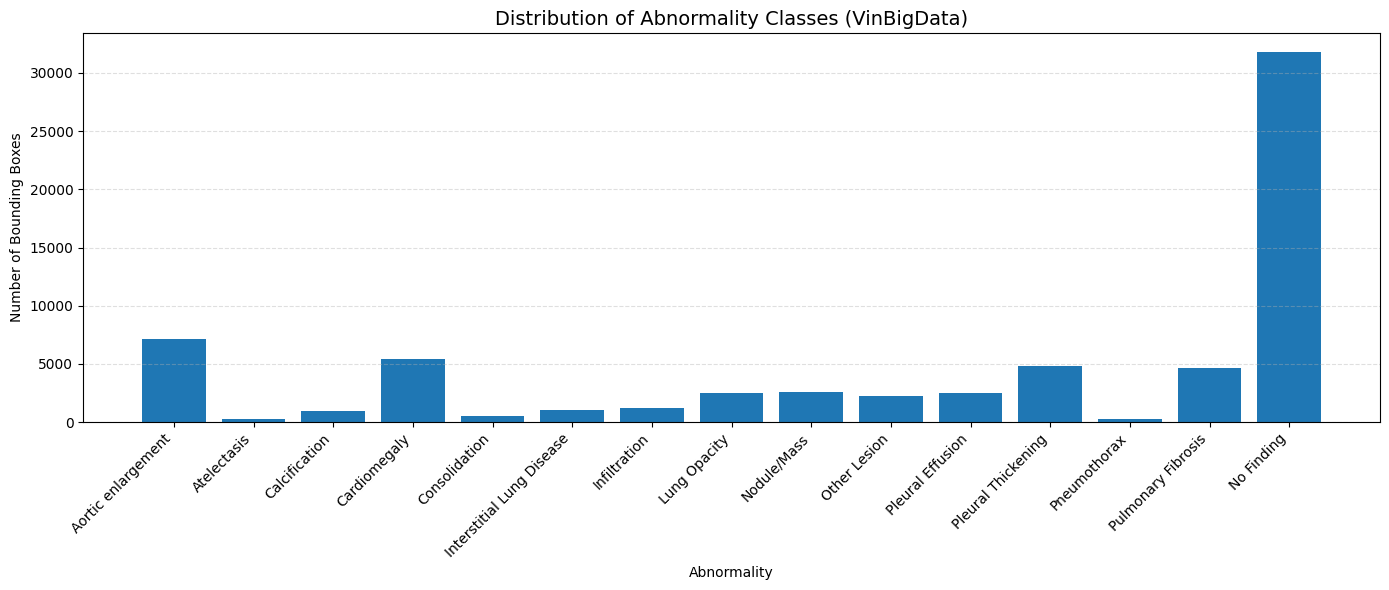

In [23]:
# ---- UPDATED CELL B (No warnings + class names + table) ----

import pandas as pd
import matplotlib.pyplot as plt

# Load annotation CSV
annot_path = os.path.join(INPUT_DIR, "train.csv")
df = pd.read_csv(annot_path)

# ---- STEP 1: Class ID → Name mapping ----
class_map = {
    0:  "Aortic enlargement",
    1:  "Atelectasis",
    2:  "Calcification",
    3:  "Cardiomegaly",
    4:  "Consolidation",
    5:  "Interstitial Lung Disease",
    6:  "Infiltration",
    7:  "Lung Opacity",
    8:  "Nodule/Mass",
    9:  "Other Lesion",
    10: "Pleural Effusion",
    11: "Pleural Thickening",
    12: "Pneumothorax",
    13: "Pulmonary Fibrosis",
    14: "No Finding"
}

# Convert mapping into a DataFrame and display it
class_df = pd.DataFrame({
    "class_id": list(class_map.keys()),
    "Abnormality": list(class_map.values())
})

print("📌 VinBigData Class Label Mapping:")
display(class_df)

# ---- STEP 2: Remove all rows without abnormalities (drop NaN class_id)
df_clean = df.dropna(subset=["class_id"]).copy()
df_clean["class_id"] = df_clean["class_id"].astype(int)

# ---- STEP 3: Count frequency of each abnormality
class_counts = df_clean["class_id"].value_counts().sort_index()

# Map counts to names
class_names = [class_map[cid] for cid in class_counts.index]

# Combine into final table
result_df = pd.DataFrame({
    "class_id": class_counts.index,
    "Abnormality": class_names,
    "Count": class_counts.values
})

print("📊 Distribution of Abnormalities:")
display(result_df)

# ---- STEP 4: Plot bar chart with class names ----
plt.figure(figsize=(14,6))
plt.bar(class_names, class_counts.values)
plt.xticks(rotation=45, ha='right')
plt.title("Distribution of Abnormality Classes (VinBigData)", fontsize=14)
plt.xlabel("Abnormality")
plt.ylabel("Number of Bounding Boxes")
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


In [24]:
# ----  Check for missing images vs annotations ----

annot = pd.read_csv(os.path.join(INPUT_DIR, "train.csv"))

# Remove extension for comparison
annot["image_id"] = annot["image_id"].astype(str)

# Convert list of PNG filenames to image IDs
png_files = [f.replace(".png", "") for f in os.listdir(FINAL_DIR) if f.endswith(".png")]

missing = []
for img_id in annot["image_id"].unique():
    if img_id not in png_files:
        missing.append(img_id)

print("🔍 Checking for missing images...")
print(f"Total annotated images    : {annot['image_id'].nunique()}")
print(f"Total processed PNG files : {len(png_files)}")
print(f"Missing images            : {len(missing)}")

if len(missing) > 0:
    print("\n❗ Missing image IDs:")
    for m in missing[:20]:   # show only first 20 for readability
        print(m)
else:
    print("\n✔ All annotated images are present.")


🔍 Checking for missing images...
Total annotated images    : 15000
Total processed PNG files : 1000
Missing images            : 14000

❗ Missing image IDs:
50a418190bc3fb1ef1633bf9678929b3
21a10246a5ec7af151081d0cd6d65dc9
9a5094b2563a1ef3ff50dc5c7ff71345
051132a778e61a86eb147c7c6f564dfe
063319de25ce7edb9b1c6b8881290140
1c32170b4af4ce1a3030eb8167753b06
0c7a38f293d5f5e4846aa4ca6db4daf1
47ed17dcb2cbeec15182ed335a8b5a9e
d3637a1935a905b3c326af31389cb846
afb6230703512afc370f236e8fe98806
7c1add6833d5f0102b0d3619a1682a64
18a61a07e6f5f13ebfee57fa36cd8b6f
869f39afbdd8783b531530942eda8bad
321c111713c3ee5385db0effb54ff568
cdbacab6bf30170ef0ba9fd1d195d270
80caa435b6ab5edaff4a0a758ffaec6e
5da264775732004f1b724b660138854a
fb8e11c6b2886b2d41b379e0598669b9
0622cd29e4e0e4f198abf15614819ae8
c6e0ab2470d98a6a8c701e774df929cc
